# P8 : Model deployment on the cloud

In [1]:
import io
import sys
import pyspark
import pyspark.sql
from pyspark import SparkContext
from pyspark.sql import SparkSession
import findspark
findspark.init()
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from PIL import Image
import cv2
from typing import Iterator
from pyspark.sql.functions import col, split, udf, pandas_udf, PandasUDFType
from pyspark.sql.types import ArrayType, DoubleType
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import StandardScaler, PCA
import tensorflow as tf
from tensorflow.keras.applications import resnet50
from tensorflow.keras.preprocessing.image import img_to_array

This project was made with Python 3.8.8, Matplotlib 3.4.2, Pandas 1.2.4, Numpy 1.20.1, Seaborn 0.11.1., Pyspark 3.0.3, tensorflow 2.8.0, Open-cv 4.5.5 (headless version), PIL 8.2.0.

Check your version number:

In [2]:
print("Python", sys.version_info.major, ".", sys.version_info.minor)
print("Matplotlib", mpl.__version__)
print("Pandas", pd.__version__)
print("Nympy", np.__version__)
print("Seaborn", sns.__version__)
print("Pyspark", pyspark.__version__)
print("Tensorflow", tf.__version__)
print("Open-cv (cv2)", cv2.__version__)
print("PIL", PIL.__version__)

Python 3 . 8
Matplotlib 3.4.2
Pandas 1.2.4
Nympy 1.20.1
Seaborn 0.11.1
Pyspark 3.0.3
Tensorflow 2.8.0
Open-cv (cv2) 4.5.5
PIL 8.2.0


## Set-up bucket and spark

Set-up spark session and spark context.

In [3]:
spark = SparkSession \
    .builder \
    .appName("computer_vision") \
    .master("local") \
    .config("spark.hadoop.google.cloud.auth.service.account.enable","true") \
    .config("google.cloud.auth.service.account.json.keyfile", "/path/to/json") \
    .getOrCreate()

In [4]:
conf = spark.sparkContext._jsc.hadoopConfiguration()
conf.set("fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem")
conf.set("fs.AbstractFileSystem.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFS")

In [5]:
#!gsutil ls gs://bucket_name/img/*

## Load images from google storage

We get all images under binary format.

In [6]:
path_img = "gs://bucket_name/img/*"
img_all = spark.read.format("binaryfile").load(path_img)
img_all.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)



We add a column indicating target class.

In [7]:
img_df = img_all.select("path", "content")
n_rows = img_df.count()
img_df = img_df.withColumn("target", split(col("path"), "/") \
    .getItem(4))
img_df.show()

+--------------------+--------------------+------------------+
|                path|             content|            target|
+--------------------+--------------------+------------------+
|gs://p8_computer_...|[FF D8 FF E0 00 1...|           cabbage|
|gs://p8_computer_...|[FF D8 FF E0 00 1...|           cabbage|
|gs://p8_computer_...|[FF D8 FF E0 00 1...|           cabbage|
|gs://p8_computer_...|[FF D8 FF E0 00 1...|apple_crimson_snow|
|gs://p8_computer_...|[FF D8 FF E0 00 1...|              pear|
|gs://p8_computer_...|[FF D8 FF E0 00 1...|apple_crimson_snow|
|gs://p8_computer_...|[FF D8 FF E0 00 1...|              pear|
|gs://p8_computer_...|[FF D8 FF E0 00 1...|apple_crimson_snow|
|gs://p8_computer_...|[FF D8 FF E0 00 1...|              pear|
+--------------------+--------------------+------------------+



## Preprocess images

Preprocessing consist in:
* Convert bytes images to numpy arrays
* Resize to 224 x 224 and add border if necessary to keep aspect ratio
* Apply the ResNet50 preprocessing

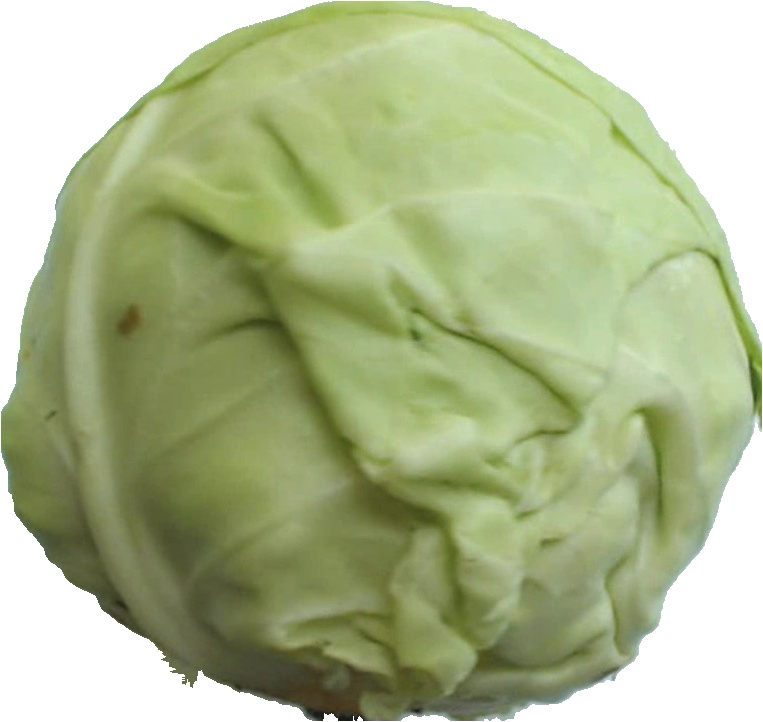

In [8]:
# Take first image of dataset
img_example = img_df.collect()[0]["content"]
# Convert from bytes to jpeg
img_example = Image.open(io.BytesIO(img_example))
img_example

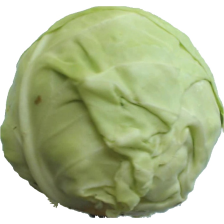

In [9]:
# Get width and height
width, height = img_example.size
# Convert to array
img_array = np.array(img_example)
# Calculate border to respect aspect ratio
border = round((width - height) / 2)
# Add border
img_border = cv2.copyMakeBorder(img_array, border, border, 0, 0, 
                                        cv2.BORDER_CONSTANT, None, value = (255, 255, 255))
# Resize to 224 x 224
img_resized = cv2.resize(img_border, (224, 224), interpolation = cv2.INTER_AREA)
img_resized_visible = Image.fromarray(np.uint8(img_resized)).convert('RGB')
img_resized_visible

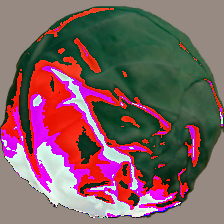

In [10]:
# With ResNet50 preprocessing
img_preprocessed = resnet50.preprocess_input(img_resized)
img_preprocessed_visible = Image.fromarray(np.uint8(img_preprocessed)).convert('RGB')
img_preprocessed_visible

## Load model

We will use the pre-trained ResNet50 model without top layers.

In [49]:
resnet = resnet50.ResNet50(weights="imagenet", include_top=False)
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

We will broadcast the weights to all spark workers nodes.

In [50]:
bc_model_weights = spark.sparkContext.broadcast(resnet.get_weights())

We define the necessary functions.

In [51]:
def model_fn():
    """
    Returns a ResNet50 model with top layer removed and broadcasted pretrained weights.
    """
    model = resnet50.ResNet50(weights=None, include_top=False) 
    model.set_weights(bc_model_weights.value)
    return model

In [52]:
def preprocess_img(bytes_img):
    """
    Convert a bytes image to numpy array.
    Resize and add a border to keep aspect ratio.
    Apply ResNet50 preprocessing.
    """
    border_color = (255, 255, 255)
    final_size = (224, 224)

    # Convert to numpy array and get width and height
    img = Image.open(io.BytesIO(bytes_img))
    width, height = img.size
    img_array = np.array(img)

    # Resize and add border if necessary
    if width == height:
        img_border=img_array
    elif height > width:
        border = round((height - width) / 2)
        img_border = cv2.copyMakeBorder(img_array, 0, 0, border, border, 
                                        cv2.BORDER_CONSTANT, None, value = border_color)
    else:
        border = round((width - height) / 2)
        img_border = cv2.copyMakeBorder(img_array, border, border, 0, 0, 
                                        cv2.BORDER_CONSTANT, None, value = border_color)
    img_resized = cv2.resize(img_border, final_size, interpolation = cv2.INTER_AREA)

    # Resnet50 preprocessing
    img_preprocessed = resnet50.preprocess_input(img_resized)

    return img_preprocessed

In [53]:
def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    Return a pd.Series of image features.
    """
    input = np.stack(content_series.map(preprocess_img)) 
    preds = model.predict(input)
    output = [p.flatten() for p in preds]
    output = pd.Series(output)
    return output

In [54]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    """
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).
    Content_series_iter: This argument is an iterator over batches of data, where each batch
    is a pandas Series of image data.
    """
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/home/fbajolet/spark-3.0.3-bin-hadoop2.7/python/pyspark/sql/pandas/functions.py:383: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


We apply our functions:
* preprocessing
* model prediction (without top layers)
* extract features and convert them into a Series

In [55]:
features_df = img_df.select(col("path"), col("target"), featurize_udf("content").alias("features"))
features_df.printSchema()
features_df.show()

root
 |-- path: string (nullable = true)
 |-- target: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)

+--------------------+------------------+--------------------+
|                path|            target|            features|
+--------------------+------------------+--------------------+
|gs://p8_computer_...|           cabbage|[0.0, 0.0, 0.0, 0...|
|gs://p8_computer_...|           cabbage|[0.0, 0.0, 0.0, 0...|
|gs://p8_computer_...|           cabbage|[0.0, 0.0, 0.0, 0...|
|gs://p8_computer_...|apple_crimson_snow|[0.0, 0.0, 0.0, 0...|
|gs://p8_computer_...|              pear|[0.0, 0.0, 0.0, 0...|
|gs://p8_computer_...|apple_crimson_snow|[0.0, 0.0, 0.0, 0...|
|gs://p8_computer_...|              pear|[0.0, 0.0, 0.0, 0...|
|gs://p8_computer_...|apple_crimson_snow|[0.0, 0.0, 0.0, 0...|
|gs://p8_computer_...|              pear|[0.0, 0.0, 0.0, 0...|
+--------------------+------------------+--------------------+



We transform our features into a dense vector.

In [56]:
list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())

features_df = features_df.select(col("path"),  col("target"), list_to_vector_udf(features_df["features"]) \
                        .alias("features"))

Now we got our features.

In [57]:
features_df.show()

+--------------------+------------------+--------------------+
|                path|            target|            features|
+--------------------+------------------+--------------------+
|gs://p8_computer_...|           cabbage|[0.0,0.0,0.0,0.0,...|
|gs://p8_computer_...|           cabbage|[0.0,0.0,0.0,0.0,...|
|gs://p8_computer_...|           cabbage|[0.0,0.0,0.0,0.0,...|
|gs://p8_computer_...|apple_crimson_snow|[0.0,0.0,0.0,0.0,...|
|gs://p8_computer_...|              pear|[0.0,0.0,0.0,0.0,...|
|gs://p8_computer_...|apple_crimson_snow|[0.0,0.0,0.0,0.0,...|
|gs://p8_computer_...|              pear|[0.0,0.0,0.0,0.0,...|
|gs://p8_computer_...|apple_crimson_snow|[0.0,0.0,0.0,0.0,...|
|gs://p8_computer_...|              pear|[0.0,0.0,0.0,0.0,...|
+--------------------+------------------+--------------------+



## PCA

First, we scale our data with a standard scaler.

In [58]:
preprocessor = StandardScaler(withMean=True, inputCol="features", outputCol="features_scaled")
preprocessor_fitted = preprocessor.fit(features_df)
features_df_scaled = preprocessor_fitted.transform(features_df)
features_df_scaled.show()

+--------------------+------------------+--------------------+--------------------+
|                path|            target|            features|     features_scaled|
+--------------------+------------------+--------------------+--------------------+
|gs://p8_computer_...|           cabbage|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|gs://p8_computer_...|           cabbage|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|gs://p8_computer_...|           cabbage|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|gs://p8_computer_...|apple_crimson_snow|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|gs://p8_computer_...|              pear|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|gs://p8_computer_...|apple_crimson_snow|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|gs://p8_computer_...|              pear|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|gs://p8_computer_...|apple_crimson_snow|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|gs://p8_computer_...|              pear|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0

And transform data with PCA.

In [59]:
def pca_pyspark(pca, data, annotate=True):
    """
    Make a PCA on data.
    Display a graph with % of variance explained by each axis and cumulated variance.
    Return reduced data.
    """
    # Fit PCA, get explained variance
    pca_fitted = pca.fit(data)
    reduced_data = pca_fitted.transform(data)
    explained_variance = pca_fitted.explainedVariance
    explained_variance_sum = explained_variance.cumsum()

    #Plot explained variance
    plt.rcParams.update({"figure.titlesize":16,
                        "axes.titlesize":16, 
                        "axes.labelsize":14, 
                        "xtick.labelsize":13,
                        "ytick.labelsize":13})
    sns.set_style("darkgrid")
    fig, ax = plt.subplots(figsize=(7, 7))

    k = pca.getK()
    x = [i for i in range(1, k+1)]
    y1 = explained_variance*100
    y2 = explained_variance_sum*100

    p1 = ax.bar(x, y1, label="% for the axis")
    p2 = ax.plot(x, y2, c="red",marker='o', label="cumulated %")        

    if annotate:
        ax.bar_label(p1, fmt="%.1f", size=13)

        for i,j in zip(x, y2):
            ax.annotate(f"{j:.1f}", xy=(i,j), ha="center", size=13, xytext=(-7, 9), textcoords='offset points')
    else:
        ax.bar_label(p1)

    ax.set_xlabel("Rank of PCA axis", fontsize=14)
    ax.set_ylabel("% of explained variance", fontsize=14)
    ax.legend(fontsize=13)
    ax.set_title("PCA explained variance", fontsize=16, pad=20)

    return reduced_data

In [60]:
pca = PCA(k=6, inputCol="features_scaled", outputCol="pca_coord")

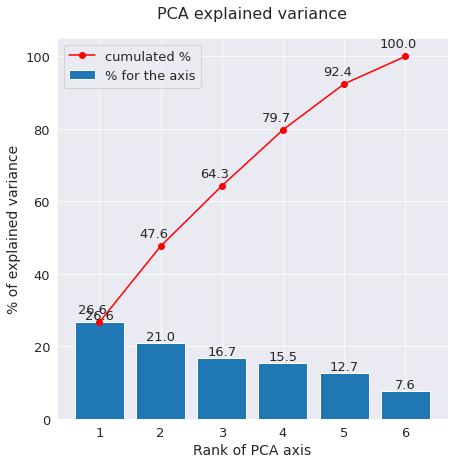

In [68]:
reduced_data = pca_pyspark(pca, features_df_scaled)

Now we break the dense vector into several columns, one per PCA feature.

In [69]:
def to_list(vec):
    """Transform a dense vector into a list."""
    return vec.toArray().tolist()

In [70]:
def split_array(col):
    """Split a list into several columns"""
    return udf(to_list, ArrayType(DoubleType()))(col)

In [72]:
final_data = reduced_data.withColumn("all_pca_coord", split_array(col("all_pca_coord")).alias("split_pca")) \
    .select(["path", "target", "features", "features_scaled", "all_pca_coord"]+[col("all_pca_coord")[i] for i in range(6)])

Here we have the full results with our features and their coordinates in PCA space.

In [73]:
final_data.printSchema()
final_data.show()

root
 |-- path: string (nullable = true)
 |-- target: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- features_scaled: vector (nullable = true)
 |-- all_pca_coord: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- all_pca_coord[0]: double (nullable = true)
 |-- all_pca_coord[1]: double (nullable = true)
 |-- all_pca_coord[2]: double (nullable = true)
 |-- all_pca_coord[3]: double (nullable = true)
 |-- all_pca_coord[4]: double (nullable = true)
 |-- all_pca_coord[5]: double (nullable = true)

+--------------------+------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
|                path|            target|            features|     features_scaled|       all_pca_coord|   all_pca_coord[0]|   all_pca_coord[1]|   all_pca_coord[2]|   all_pca_coord[3]|   all_pca_coord[4]|   all_pca_coord[5]|
+--

## Export results to storage

Convert to pandas dataframe and csv, then export.

In [25]:
data_pca = final_data.select("path", "target", "pca_coord")
data_pca = data_pca.toPandas()

In [26]:
data_pca.to_csv("gs://p8_computer_vision/data_pca.csv", index=False)